In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [24]:
# Dependencies
from pymongo import MongoClient
import pandas as pd
import numpy as np

from urls_list import * #where all urls and paths are saved

## Read the historic rental data

In [56]:
client = MongoClient(db_connection_string)
records = list(client.ETLInsights["HistoricRental"].find({}, {'_id':0}))

In [274]:
DF = pd.DataFrame(records)

In [275]:
#Replace all white spaces or nothing at all to NaN
DF.replace(r'^\s*$', np.nan, regex=True, inplace=True)
#Replace None with NaN
DF = DF.fillna(value=np.nan)

## Missing Data Analysis

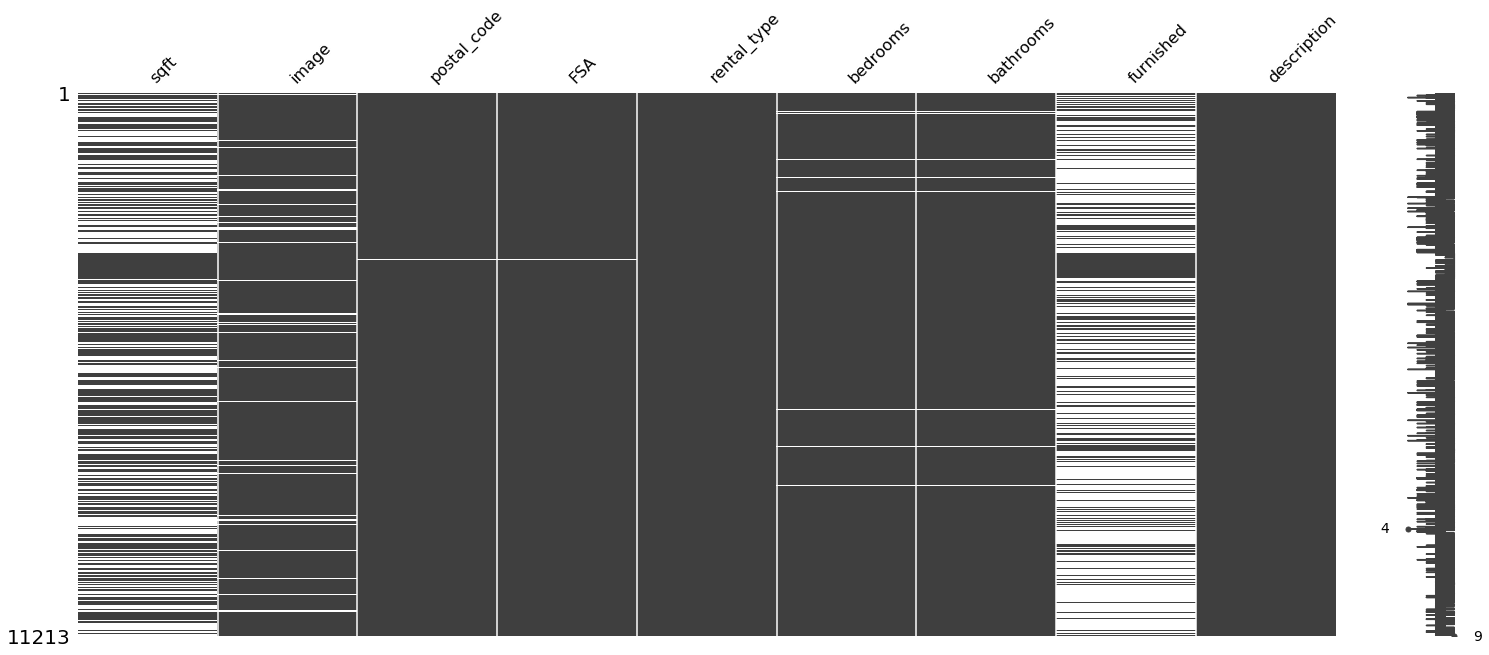

In [276]:
missingdata_col = DF.columns[DF.isnull().any()].tolist()
import matplotlib
import missingno as msno
%matplotlib inline
msno.matrix(DF[missingdata_col])

#### Make FSA and rental_type mandatory. If they are not retrieved in the rental posting, ML will not run, citing an exception

In [277]:
DF.drop(DF[DF[['FSA', 'rental_type']].isna().any(axis=1)].index, inplace=True)

# [1373, 3234, 3320, 3332, 3347, 3452, 3474, 3512, 3569, 3574, 3616,
#             3678, 3703, 3711, 3765, 3795, 3816, 3825, 7601, 8374, 8473, 8680,
#             9053, 9366, 9632]

## Type casting

In [278]:
DF['price'] = DF['price'].astype('int')

#Convert post_published_date to week of the month
from datetime import datetime
DF['post_published_date'] = DF['post_published_date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

#New features
DF['posted_week_of_month'] = DF['post_published_date'].map(lambda x: x.day//7 +1)

## Missing value handling

In [279]:
DF['furnished'] = DF['furnished'].fillna(value="NOT_MENTIONED")
DF['furnished'] = DF['furnished'].replace(to_replace=True, value='YES')
DF['furnished'] = DF['furnished'].replace(to_replace=False, value='NO')
#Convert image url to image or not?
DF['image'] = DF['image'].notna()

## Basic Transformations

In [280]:
num_columns = ['sqft', 'bedrooms', 'bathrooms', 'posted_week_of_month']
cat_columns = ['image', 'FSA', 'rental_type', 'furnished', 'pet_friendly']
nlp_scope_columns = ['title', 'description']
DF.reset_index(drop=True, inplace=True)
X = DF[num_columns + cat_columns]
Y = DF['price']


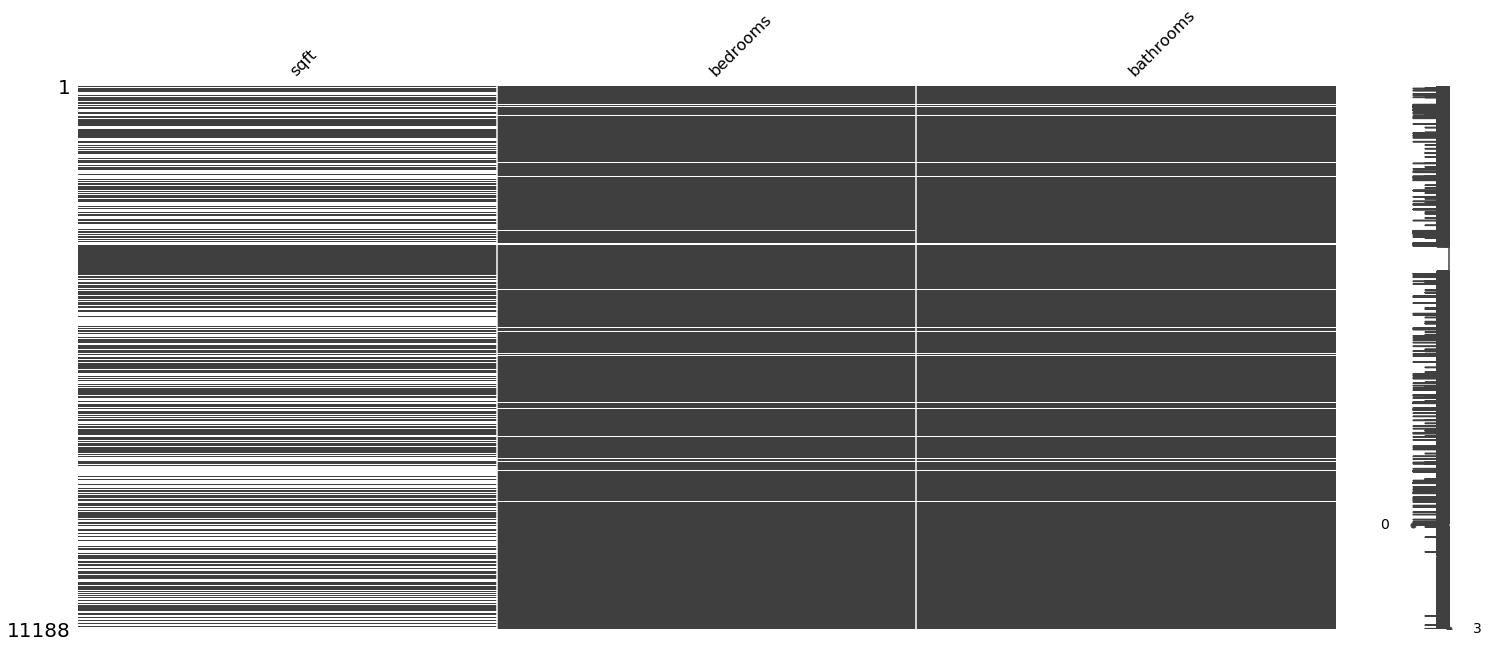

In [285]:
missingdata_col = X.columns[X.isnull().any()].tolist()
import matplotlib
import missingno as msno
%matplotlib inline
msno.matrix(X[missingdata_col])

### One Hot Encoding

In [282]:
from sklearn.model_selection import train_test_split

##OHE
enc = OneHotEncoder()
##OHE Fit
enc.fit(X[cat_columns])
##OHE Transform
ohe_output = enc.transform(X[cat_columns]).toarray()
##Retrieve OHE labels
ohe_dict = {f'x{index}':col for index,col in enumerate(cat_columns)}
ohe_labels = [ohe_dict[feature.split('_')[0]]+'_'+feature.split('_')[1] for feature in enc.get_feature_names()]
X = pd.concat([X, pd.DataFrame(ohe_output, columns=ohe_labels)], axis=1)
X.drop(cat_columns, axis=1, inplace=True)


OneHotEncoder()

## Train Test Split

In [286]:
seed = 100
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3)


## Base Model

In [289]:
X_train.shape

(7831, 164)

,sqft,bedrooms,bathrooms,posted_week_of_month,image_False,image_True,FSA_L0H,FSA_L1G,FSA_L1J,FSA_L1K,...,rental_type_house,rental_type_land,rental_type_loft,rental_type_suite,rental_type_townhouse,furnished_NO,furnished_NOT,furnished_YES,pet_friendly_False,pet_friendly_True
4752,NaN,1.0,1.0,5,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3632,565.0,1.0,1.0,2,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4056,600.0,1.0,1.0,4,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6173,600.0,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5610,NaN,4.0,4.0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,505.0,1.0,1.0,4,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
79,NaN,1.0,1.0,4,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8039,NaN,1.0,1.0,3,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6936,NaN,3.0,3.0,2,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
